In [48]:
import soundfile as sfl
import torch
from espnet2.torch_utils.device_funcs import to_device
import dac
from espnet2.asr.frontend.default import DefaultFrontend
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import torchvision

In [106]:
frontend = DefaultFrontend(n_fft = 512, 
                           win_length = 400, 
                           hop_length = 160)

In [31]:
frontend

DefaultFrontend(
  (stft): Stft(n_fft=512, win_length=400, hop_length=160, center=True, normalized=False, onesided=True)
  (frontend): Frontend()
  (logmel): LogMel(sr=16000, n_fft=512, n_mels=80, fmin=0, fmax=8000.0, htk=False)
)

In [32]:
aud, sf = sfl.read("/data/anakuzne/LibriSpeech/train-clean-100/103/1240/103-1240-0014.flac")

In [33]:
ipd.Audio(aud, rate=sf)

## Check truncated SVD compression

In [34]:
input = torch.tensor(aud).float()
lens = input.shape[0]
input = input.view(1, lens, 1)

In [35]:
input_lens = torch.tensor([lens])
input_lens

tensor([223360])

In [36]:
input.shape

torch.Size([1, 223360, 1])

In [37]:
mel_spec, mel_lens, _, _ = frontend(input, input_lens)

In [91]:
mel_spec = mel_spec/torch.norm(mel_spec)

In [95]:
mel_spec.sum()

tensor(-317.4263)

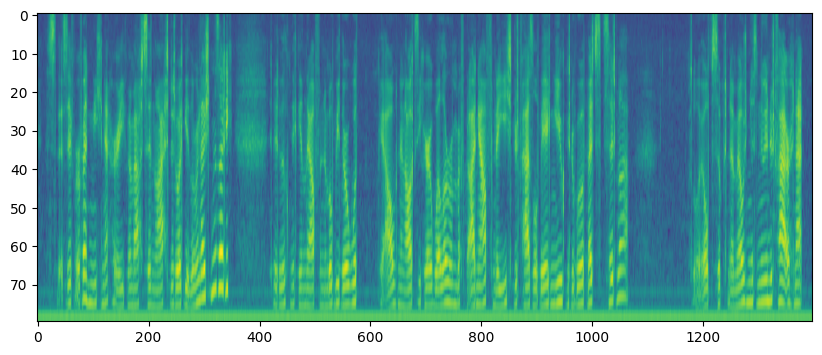

In [96]:
plt.figure(figsize=(10, 4))
plt.imshow(np.flip(mel_spec.squeeze(0).numpy().T), aspect="auto")
plt.show()

In [97]:
U, S, Vh = torch.linalg.svd(mel_spec.squeeze(0), full_matrices=False)
S = torch.diag(S)

In [98]:
print(U.shape, S.shape, Vh.shape)

torch.Size([1397, 80]) torch.Size([80, 80]) torch.Size([80, 80])


In [99]:
rank = 1

res = U[:, :rank] @ S[:rank, :rank] @ Vh[:rank]

In [100]:
res.shape

torch.Size([1397, 80])

In [101]:
res.sum()

tensor(-317.8028)

In [102]:
mel_spec.sum()

tensor(-317.4263)

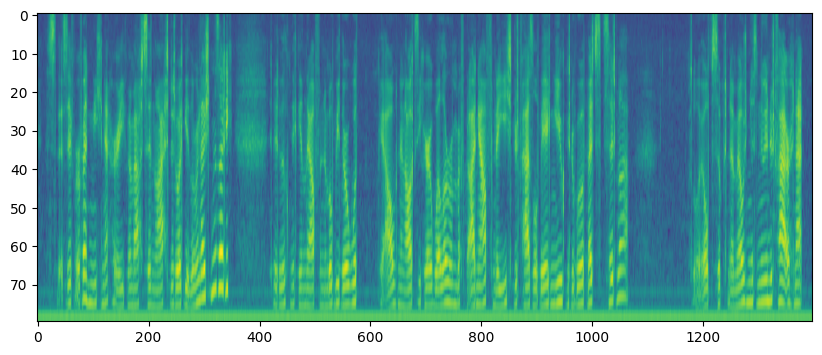

In [103]:
plt.figure(figsize=(10, 4))
plt.imshow(np.flip(mel_spec.numpy().T), aspect="auto")
plt.show()

In [49]:
import imageio as iio

In [50]:
img = iio.imread("/data/anakuzne/espnet/doc/image/espnet_logo1.png")

/tmp/ipykernel_70015/4043075823.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = iio.imread("/data/anakuzne/espnet/doc/image/espnet_logo1.png")


In [51]:
img = torch.Tensor(img)[:, :,0]

In [59]:
img.sum()

tensor(5760967.)

In [60]:
res.sum()

tensor(5730349.5000)

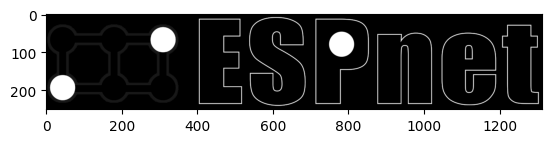

In [53]:
plt.imshow(img.numpy(), cmap="gray")

In [54]:
U, S, VT = torch.linalg.svd(img)
S = torch.diag(S)

In [55]:
print(U.shape, S.shape, VT.shape)

torch.Size([251, 251]) torch.Size([251, 251]) torch.Size([1313, 1313])


In [56]:
rank = 10

res = U[:, :rank] @ S[:rank, :rank] @ VT[:rank]

In [57]:
res.shape

torch.Size([251, 1313])

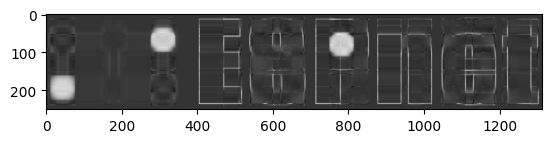

In [58]:
plt.imshow(res.numpy(), cmap="gray")

In [4]:
model_path = dac.utils.download(model_type="16khz")
model = dac.DAC.load(model_path)

model = model.to('cuda:5')

/home/anakuzne/.local/lib/python3.8/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


In [5]:
model

DAC(
  (encoder): Encoder(
    (block): Sequential(
      (0): Conv1d(1, 64, kernel_size=(7,), stride=(1,), padding=(3,))
      (1): EncoderBlock(
        (block): Sequential(
          (0): ResidualUnit(
            (block): Sequential(
              (0): Snake1d()
              (1): Conv1d(64, 64, kernel_size=(7,), stride=(1,), padding=(3,))
              (2): Snake1d()
              (3): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
            )
          )
          (1): ResidualUnit(
            (block): Sequential(
              (0): Snake1d()
              (1): Conv1d(64, 64, kernel_size=(7,), stride=(1,), padding=(9,), dilation=(3,))
              (2): Snake1d()
              (3): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
            )
          )
          (2): ResidualUnit(
            (block): Sequential(
              (0): Snake1d()
              (1): Conv1d(64, 64, kernel_size=(7,), stride=(1,), padding=(27,), dilation=(9,))
              (2): Snake1d()
              

In [8]:
input_dac = input.view(1, 1, lens).to("cuda:5")

In [9]:
input_dac.shape

torch.Size([1, 1, 223360])

In [10]:
#input_dac = torch.rand(2, 1, 223360).to("cuda:5")

In [21]:
z, codes, latents, _, _ = model.encode(input_dac, n_quantizers=1)
print(z.shape)
y = model.decode(z)

torch.Size([1, 1024, 698])


In [22]:
y.shape

torch.Size([1, 1, 223352])

In [23]:
y_out = y.squeeze(0).squeeze(0).detach().cpu().numpy()

In [20]:
ipd.Audio(aud, rate=sf)

In [24]:
ipd.Audio(y_out, rate=sf)

In [27]:
layer_conv1d = torch.nn.Conv1d(1024, 80, 3, 2).to("cuda:5")

In [28]:
out_conv1d = layer_conv1d(z)

In [30]:
out_conv1d.shape

torch.Size([1, 80, 348])

In [135]:
from espnet.nets.pytorch_backend.transformer.embedding import PositionalEncoding

class Conv2dSubsampling(torch.nn.Module):
    def __init__(self, idim, odim):
        super(Conv2dSubsampling, self).__init__()

        self.conv = torch.nn.Sequential(
            torch.nn.Conv2d(1, odim, 3, 2),
            torch.nn.ReLU(),
            torch.nn.Conv2d(odim, odim, 3, 2),
            torch.nn.ReLU(),
        )
        self.out = torch.nn.Sequential(
            torch.nn.Linear(odim * (((idim - 1) // 2 - 1) // 2), odim), PositionalEncoding(odim, 0.1)
        )

    def forward(self, x):
        x = self.conv(x)
        print(f"Conv: {x.shape}")
        b, c, t, f = x.size()
        x = self.out(x.transpose(1, 2).contiguous().view(b, t, c * f))
        print(f"Linear: {x.shape}")
        return x

In [136]:
embed = Conv2dSubsampling(1024, 1024).to("cuda:7")

In [137]:
z.shape

torch.Size([1, 1, 436, 1024])

In [138]:
embed_out = embed(z)

Conv: torch.Size([1, 1024, 108, 255])
Linear: torch.Size([1, 108, 1024])


In [140]:
embed_out.min()

tensor(-65.9272, device='cuda:7', grad_fn=<MinBackward1>)

In [141]:
embed_out.max()

tensor(63.6269, device='cuda:7', grad_fn=<MaxBackward1>)